# Explore basins and states: all-to-all

In [1]:
import sys
from itertools import combinations
from math import sin
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from tqdm import tqdm

sys.path.append("../code/")

import xgi
from kuramoto_hoi import *

sb.set_theme(style="ticks", context="notebook")

results_dir = "../results/"
data_dir = "../data/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

## Generate structure

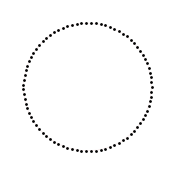

In [4]:
fig, ax = plt.subplots(figsize=(2, 2))
pos = xgi.circular_layout(H)

ax, ims = xgi.draw(H2, pos=pos, ax=ax, node_size=1, edge_fc="r", node_labels=False)

plt.show()

In [5]:
# may be used in the simulation function
links = H.edges.filterby("size", 2).members()
triangles = H.edges.filterby("size", 3).members()
adj1 = xgi.adjacency_matrix(H, order=1, sparse=False)
adj2 = xgi.adjacency_matrix(H, order=2, sparse=False)
k1_avg = H.nodes.degree(order=1).mean()
k2_avg = H.nodes.degree(order=2).mean()

## Dynamics

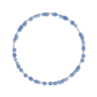

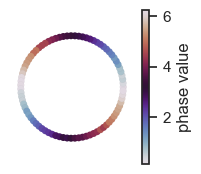

In [30]:
# Set parameters

# dynamical
k1 = 1  # pairwise coupling strength
k2 = 1  # triplet coupling strength
omega = 0 #1 * np.ones(N)  # np.random.normal(size=N) #1 * np.ones(N)

ic = "random"  # initial condition type, see below
noise = 1e-1  # noise strength
p2 = None

psi_init = generate_state(N=83, kind="q-twisted", q=2, noise=noise)

# integration
t_end = 400
dt = 0.01
times = np.arange(0, t_end + dt / 2, dt)

tag_params = f"k1_{k1}_k2_{k2}_ic_{ic}"

fig, ax = plt.subplots(figsize=(1, 1))
plot_phases(psi_init, it=None, ax=ax)
plt.show()

# only to viz twisted states
fig, ax = plt.subplots(figsize=(2, 2))
ax, ims = xgi.draw(
    H, pos=pos, node_fc=psi_init % (2 * np.pi), node_fc_cmap="twilight", node_size=5, node_lw=0.01
)
plt.colorbar(ims, label="phase value")

In [245]:
def rhs_pairwise_triplet_all_sym(t, psi, omega, k1, k2):
    out = (
        rhs_pairwise_all(t, psi, omega, k1, k2)
        + rhs_triplet_all_sym(t, psi, omega, k1, k2)
        - omega
    )

    return out


def rhs_pairwise_triplet_all_asym(t, psi, omega, k1, k2):
    out = (
        rhs_pairwise_all(t, psi, omega, k1, k2)
        + rhs_triplet_all_asym(t, psi, omega, k1, k2)
        - omega
    )

    return out


def rhs_pairwise_triplet_all_sym(t, psi, omega, k1, k2):
    out = (
        rhs_pairwise_all(t, psi, omega, k1, k2)
        + rhs_triplet_all_sym(t, psi, omega, k1, k2)
        - omega
    )

    return out


from numba import jit


def rhs_23_nn_sym_micro(t, psi, omega, k1, k2, r1, r2, links, triangles):
    N = len(psi)
    pairwise = np.zeros(N)
    triplet = np.zeros(N)

    for i, j in links:
        # sin(oj - oi)
        oi = psi[i]
        oj = psi[j]
        pairwise[i] += sin(oj - oi)
        pairwise[j] += sin(oi - oj)

    for i, j, k in triangles:
        # sin(2 oj - ok - oi)
        oi = psi[i]
        oj = psi[j]
        ok = psi[k]
        triplet[i] += 2 * sin(oj + ok - 2 * oi)
        triplet[j] += 2 * sin(oi + ok - 2 * oj)
        triplet[k] += 2 * sin(oj + oi - 2 * ok)

    g1 = r1
    g2 = r2 * (2 * r2 - 1)

    return omega + (k1 / r1) * pairwise + (k2 / g2) * (triplet / 2)

from itertools import permutations

def adjacency_tensor(H, order):
    N = H.num_nodes
    shape = tuple([N] * (order + 1))
    tensor = np.zeros(shape)

    edges = H.edges.filterby("order", order)
    for id, members in edges.members(dtype=dict).items():
        for idcs in permutations(members):
            tensor[idcs] = 1

    return tensor

adjt2 = adjacency_tensor(H, 2)

def rhs_23_nn_sym(t, psi, omega, k1, k2, r1, r2, adj1, triangles, adjt2):
        
    N = len(psi)
    sin_psi = np.sin(psi)
    cos_psi = np.cos(psi)

    pairwise = adj1.dot(sin_psi) * cos_psi - adj1.dot(cos_psi) * sin_psi

    triplet = np.zeros(N)
    
    #print(len(triangles))
    for i, j, k in triangles:
        #print(i,j,k)
        # sin(2 oj - ok - oi)
        oi = psi[i]
        oj = psi[j]
        ok = psi[k]
        triplet[i] += 2 * sin(oj + ok - 2 * oi)
        triplet[j] += 2 * sin(oi + ok - 2 * oj)
        triplet[k] += 2 * sin(oj + oi - 2 * ok)
    #sin_psi = np.sin(psi, dtype=np.longdouble)
    #cos_psi = np.cos(psi, dtype=np.longdouble)

    #sum_sin_psi = adjt2.dot(sin_psi)
    #sum_cos_psi = adjt2.dot(cos_psi)

    #triplet = (
    #    -2 * sum_cos_psi.dot(cos_psi) * sin_psi * cos_psi
    #    + 2 * sum_sin_psi.dot(sin_psi) * sin_psi * cos_psi
    #    + sum_cos_psi.dot(sin_psi) * cos_psi**2
    #    + sum_cos_psi.dot(sin_psi) * sin_psi**2
    #    + sum_sin_psi.dot(cos_psi) * cos_psi**2
    #    + sum_sin_psi.dot(cos_psi) * sin_psi**2
    #)


    g1 = r1
    g2 = r2 * (2 * r2 - 1)

    return (k2 / g2) * triplet #omega + (k1 / g1) * pairwise #+ (k2 / g2) * triplet


def rhs_yuan(t, theta, N, K1, K2, sigma):
    dtheta_dt = np.zeros(N)

    # pairwise coupling
    #for ii in range(N):
    #    for jj in range(-K1,K1+1):
    #        dtheta_dt[ii] +=  np.sin(theta[(ii+jj)%N] - theta[ii])/K1
    #tris = []
    # triadic coupling
    idx = list(range(-K2,0)) + list(range(1,K2+1))
    for ii in range(N):
        for jj in idx:
            for kk in idx:
                if jj != kk:
                    #tris.append([ii, (ii+jj)%N, (ii+kk)%N])
                    #print([ii, (ii+jj)%N, (ii+kk)%N])
                    dtheta_dt[ii] +=  sigma*sin(theta[(ii+kk)%N] + theta[(ii+jj)%N] - 2*theta[ii])/(K2*(2.0*K2-1))
    
    #print(len(tris))
    return dtheta_dt#, tris

In [315]:
K2 = 2
idx = list(range(-K2, 0)) + list(range(1, K2 + 1))
sigma = 1 

ii = 0
dtheta_dt = np.zeros(N)
for jj in idx:
    for kk in idx:
        if jj != kk:
            # tris.append([ii, (ii+jj)%N, (ii+kk)%N])
            # print([ii, (ii+jj)%N, (ii+kk)%N])
            val = (
                sigma
                * sin(psi_init[(ii + kk) % N] + psi_init[(ii + jj) % N] - 2 * psi_init[ii])
                / (K2 * (2.0 * K2 - 1))
            )
            print(ii, (ii + jj) % N, (ii + kk) % N)
            print(val)
            dtheta_dt[ii] += val
            
print()
print(dtheta_dt[ii])

0 81 82
-0.02337755239331261
0 81 1
0.16370227859185088
0 81 2
0.0591208764491055
0 82 81
-0.02337755239331261
0 82 1
-0.00500234829344958
0 82 2
0.16321908031041057
0 1 81
0.16370227859185088
0 1 82
-0.00500234829344958
0 1 2
-0.08473942508819787
0 2 81
0.0591208764491055
0 2 82
0.16321908031041057
0 2 1
-0.08473942508819787

0.5458458191528138


In [316]:
H.nodes.memberships(0)

#triangles

{0, 1, 2, 3, 166, 167, 168, 171, 172, 173, 410, 411, 412, 415, 416, 417}

In [317]:
tri_i = [{0, 1, 81}, {0, 2, 81}, {0, 2, 82}, {0, 81, 82}, {0, 1, 82}, {0, 1, 2}]

In [318]:
triplet = np.zeros(N)
    
#print(len(triangles))
for i, j, k in tri_i:
    #print(i,j,k)
    print(i, j, k)
    # sin(2 oj - ok - oi)
    oi = psi_init[i]
    oj = psi_init[j]
    ok = psi_init[k]
    triplet[i] += 2 * sin(oj + ok - 2 * oi)
    triplet[j] += 2 * sin(oi + ok - 2 * oj)
    triplet[k] += 2 * sin(oj + oi - 2 * ok)
    
    print(sin(oj + ok - 2 * oi) * k2 / (r2 * (2 * r2 - 1)))

0 1 81
0.16370227859185088
0 81 2
0.0591208764491055
0 2 82
0.16321908031041057
0 81 82
-0.02337755239331261
0 1 82
-0.00500234829344958
0 1 2
-0.08473942508819787


In [319]:
triplet[0] * k2 / (r2 * (2 * r2 - 1))

0.5458458191528136

In [314]:
psi_init = generate_state(N=83, kind="random", k=2, ps=[0.3, 0.7], noise=0.1)


In [247]:
from scipy.integrate import odeint, solve_ivp

In [260]:
#x = odeint(rhs_yuan, psi_init, times, args=(N, r1, r2, k2))
solx = solve_ivp(rhs_yuan, [times[0], times[-1]], psi_init, args=(N, r1, r2, k2))

In [261]:
#y = odeint(rhs_23_nn_sym, psi_init, times, args=(omega, k1, k2, r1, r2, adj1, triangles, adjt2))
soly = solve_ivp(rhs_23_nn_sym, [times[0], times[-1]], psi_init, args=(omega, k1, k2, r1, r2, adj1, triangles, adjt2))

In [270]:
solx.y.shape

(83, 709)

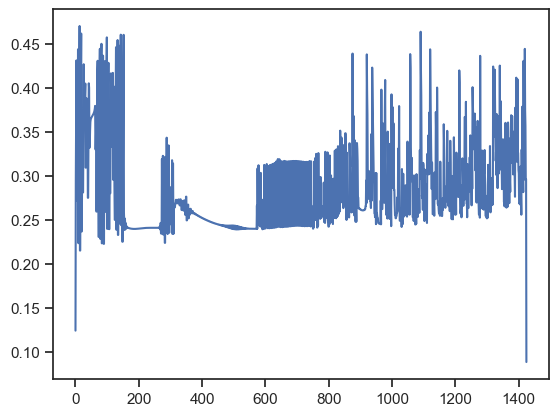

In [276]:
plt.plot(np.diff(soly.t))

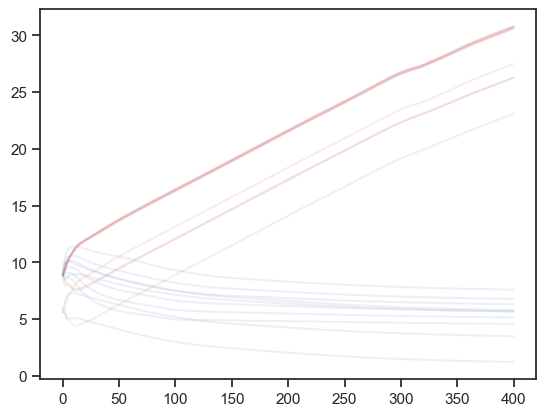

In [277]:
plt.plot(solx.t, solx.y[:10].T, "b-", alpha=0.1)
plt.plot(soly.t, soly.y[:10].T, "r-", alpha=0.1)

plt.show()

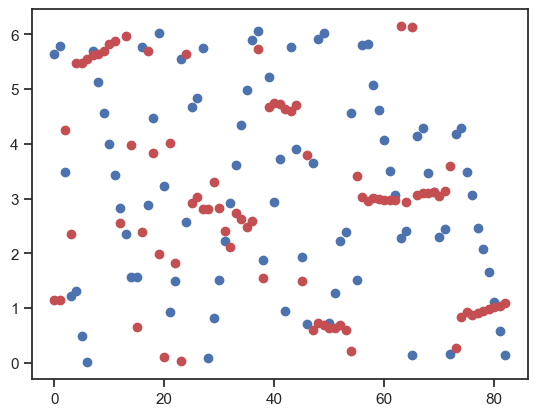

In [265]:
plt.plot(solx.y[:,-1] % (2*np.pi), "bo")

plt.plot(soly.y[:,-1] % (2*np.pi), "ro")



In [323]:
xx = rhs_23_nn_sym(0, psi_init, omega, k1, k2, r1, r2, adj1, triangles, adjt2)
xx

array([ 0.12352571,  1.02626176,  0.11091855,  0.16543684,  0.20654299,
        0.04757914, -0.44682737,  0.41931573,  1.0776167 , -0.48615376,
       -0.31353311, -0.83096984,  0.63647242,  0.9246439 , -0.45610094,
        1.22911824, -0.58141011, -0.56533845, -0.79276863, -0.36524089,
        1.76281254, -1.79023821,  0.77007406,  0.93434653,  0.11750154,
        0.43167101, -2.02297768,  2.0079546 ,  0.31944941,  0.94093409,
       -0.24466059,  1.45632425,  0.36359501, -1.75005207, -0.38697375,
        1.12980908,  1.40783856, -1.29931584, -1.53328705, -1.86429598,
       -1.34361397, -0.51124659,  0.62928814,  0.69056644,  0.14794242,
        1.14449864,  0.00529754, -0.06894165, -0.84056542, -0.6500664 ,
       -0.77127844, -0.72309537,  0.76624825,  0.60519588, -0.32178429,
       -0.33423544, -0.09729682,  0.75758362, -1.18213533, -1.53707536,
       -0.17601988,  1.46183715, -0.47646837, -0.47040136,  0.61356075,
       -0.5118599 ,  0.80823401,  0.65389437,  1.29512043, -0.57

In [324]:
yy = rhs_yuan(0,psi_init, N, r1, r2, k2)
yy

array([ 0.54584582,  1.33352015, -0.07858275,  0.43712631,  0.37710009,
       -0.00934399, -0.13684939,  0.16929347,  0.3571342 ,  0.01699381,
       -0.49692975, -0.16241645,  0.39516718,  0.19131964, -0.08247624,
        0.21057833,  0.00219777, -0.06055051,  0.5852415 , -0.58101276,
        0.73245594, -1.10520282,  0.39377015,  0.36765092,  0.11402356,
        1.17782782, -1.40216273,  1.59550703, -0.31740265,  0.31040411,
        0.3526894 ,  0.76453832,  0.02298703, -0.47677839,  0.76588629,
        0.13720669,  1.2111355 , -0.70936021, -0.83596707, -0.7198597 ,
       -0.24236147, -0.05472426, -0.22425461,  0.35387372,  0.82062863,
        0.30921297,  0.14178998, -0.09433773, -0.36852808,  0.16921326,
       -0.4709587 ,  0.24097996,  0.01859939,  0.08474497,  0.22529965,
        0.52755028, -0.46624268,  0.5523427 , -0.81985246, -1.21039444,
       -0.28702613,  0.58294426,  0.53306937, -0.3151658 ,  0.36298182,
       -0.20428717,  0.37524841,  0.15518477,  1.58796454,  0.00

In [325]:
set([frozenset(e) for e in tris]) == set([frozenset(e) for e in triangles])

True

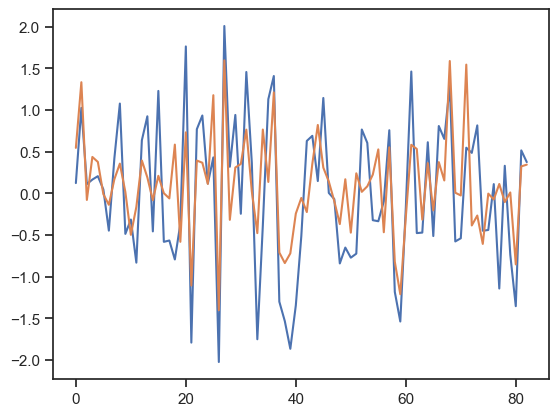

In [326]:
plt.plot(xx)
plt.plot(yy)

In [136]:
n_reps = 10

# simulate
kwargs = {
    "adj1": adj1,
#    "links": links,
    "triangles": triangles,
#    "k1_avg": k1_avg,
#    "k2_avg": k2_avg,
    "r1": r1,
    "r2": r2,
}

thetas_arr = np.zeros((n_reps, N, len(times)))

for i in tqdm(range(n_reps)):
    psi_init = generate_state(N, kind="random", noise=noise)

    thetas, times = simulate_kuramoto(
        H,
        k1,
        k2,
        omega=omega,
        theta_0=psi_init,
        t_end=t_end,
        dt=dt,
        rhs=rhs_23_nn_sym,  # rhs_pairwise_all
        **kwargs
    )

    thetas_arr[i] = thetas

  0%|                                                    | 0/10 [00:00<?, ?it/s]


TypeError: rhs_23_nn_sym() missing 1 required positional argument: 'adjt2'

(0, True)
sync


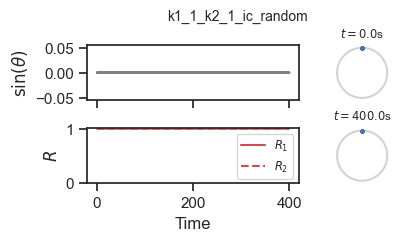

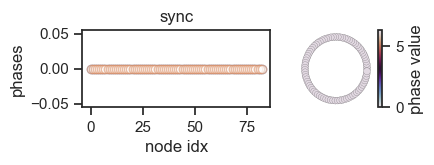

In [137]:
# plot the last repetition
i = 4
fig, axs = plot_sync(thetas_arr[i], times)

axs[0, 1].set_title(f"$t={times[0]}$s", fontsize="x-small")
axs[1, 1].set_title(f"$t={times[-1]}$s", fontsize="x-small")

axs[0, 0].set_xlabel("")
axs[1, 0].legend(loc="best", fontsize="x-small")

plt.subplots_adjust(hspace=0.5, top=0.8)

fig.suptitle(tag_params, fontsize="small")

# only to viz twisted states
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 1), width_ratios=[2, 1])

ax1.plot(thetas_arr[i, :, -1] % (2 * np.pi), "o", mfc="w", alpha=0.5)
ax1.plot(thetas_arr[i, :, -10000] % (2 * np.pi), "o", mfc="w", alpha=0.5)
ax1.set_ylabel("phases")
ax1.set_xlabel("node idx")

ax1.set_title(identify_state(thetas_arr[i], atol=0.01))

ax2, ims = xgi.draw_nodes(
    H,
    pos=pos,
    node_fc=thetas_arr[i, :, -1] % (2 * np.pi),
    node_fc_cmap="twilight",
    node_size=5,
    node_lw=0.1,
    vmin=0, 
    vmax=6.28
)
plt.colorbar(ims, label="phase value")

print(identify_winding_number(thetas_arr[i], t=-1))
#print(winding_number(thetas_arr[i].T, N, -1, atol=0.5))
print(identify_state(thetas_arr[i], atol=0.001))


In [34]:
states = [identify_state(thetas, atol=0.01) for thetas in thetas_arr]
set(states)

{'-1-twisted', '2-cluster', 'other', 'sync'}

In [35]:
states_unique, counts = np.unique(states, return_counts=True)
states_unique, counts

(array(['-1-twisted', '2-cluster', 'other', 'sync'], dtype='<U10'),
 array([1, 2, 4, 3]))

In [36]:
states

['-1-twisted',
 'sync',
 'sync',
 'other',
 'other',
 'sync',
 'other',
 'other',
 '2-cluster',
 '2-cluster']

(array([1., 0., 0., 3., 0., 0., 4., 0., 0., 2.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

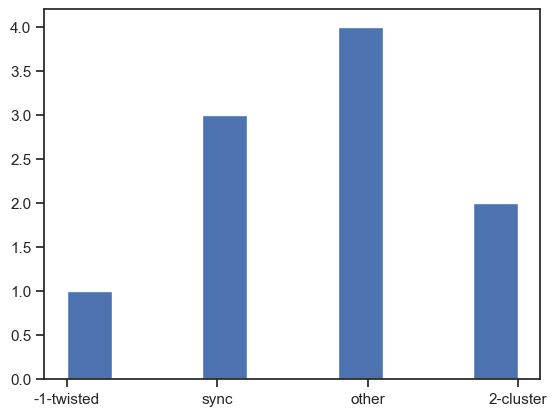

In [37]:
plt.hist(states)

(2, True)
(0, False)
yes twist
2-twisted


ValueError: 'c' argument has 83 elements, which is inconsistent with 'x' and 'y' with size 10.

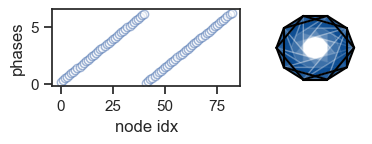

In [136]:
phi = generate_q_twisted_state(N, q=1, noise=0.001)

print(identify_winding_number(phi[:, None], t=-1))
print(winding_number(phi[None, :], N, -1))
print(identify_state(phi[:, None], atol=0.001))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 1), width_ratios=[2, 1])

ax1.plot(phi[:, None] % (2 * np.pi), "o", mfc="w", alpha=0.5)
ax1.set_ylabel("phases")
ax1.set_xlabel("node idx")

#ax1.set_title(identify_state(thetas, atol=0.01))

ax2, ims = xgi.draw(
    H,
    pos=pos,
    node_fc=phi[:, None] % (2 * np.pi),
    node_fc_cmap="twilight",
    node_size=5,
    node_lw=0.1
)
plt.colorbar(ims, label="phase value")

## Loop over k2

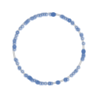

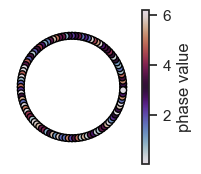

In [14]:
###### Set parameters

# dynamical
k1 = 1  # pairwise coupling strength
k2 = 0  # triplet coupling strength
omega = 1 * np.ones(N)  # np.random.normal(size=N) #1 * np.ones(N)

ic = "random"  # initial condition type, see below
noise = 1e-1  # noise strength
p2 = None


psi_init = generate_state(N, kind=ic, q=2, noise=noise)

# integration
t_end = 200
dt = 0.01
times = np.arange(0, t_end + dt / 2, dt)

tag_params = f"k1_{k1}_k2_{k2}_ic_{ic}"

fig, ax = plt.subplots(figsize=(1, 1))
plot_phases(psi_init, it=None, ax=ax)
plt.show()

# only to viz twisted states
fig, ax = plt.subplots(figsize=(2, 2))
ax, ims = xgi.draw(
    H, pos=pos, node_fc=psi_init % (2 * np.pi), node_fc_cmap="twilight", node_size=5
)
plt.colorbar(ims[0], label="phase value")

In [15]:
n_reps = 10

k2s = [0, 0.5, 1, 1.5, 2, 2.5, 3]

# simulate
kwargs = {
    "links": links,
    "triangles": triangles,
    #    "k1_avg": k1_avg,
    #    "k2_avg": k2_avg
    "r1": r1,
    "r2": r2,
}

thetas_arr = np.zeros((n_reps, len(k2s), N, len(times)))

for j, k2 in enumerate(k2s):
    for i in tqdm(range(n_reps)):
        psi_init = generate_state(N, kind="random", noise=noise)

        thetas, times = simulate_kuramoto(
            H,
            k1,
            k2,
            omega=omega,
            theta_0=psi_init,
            t_end=t_end,
            dt=dt,
            rhs=rhs_23_nn_sym,  # rhs_pairwise_all  #rhs_triplet_all_asym
            **kwargs
        )

        thetas_arr[i, j] = thetas

100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


In [62]:
results = {}

for j, k2 in enumerate(tqdm(k2s)):
    states = [identify_state(thetas, atol=0.5) for thetas in thetas_arr[:, j]]
    states_unique, counts = np.unique(states, return_counts=True)
    probs = counts / n_reps

    results[k2] = {}
    for state, prob in zip(states_unique, probs):
        results[k2][state] = prob

100%|█████████████████████████████████████████████| 7/7 [01:41<00:00, 14.46s/it]


In [63]:
results

{0: {'-1-twisted': 0.07,
  '-2-twisted': 0.02,
  '-3-twisted': 0.02,
  '1-twisted': 0.04,
  '2-twisted': 0.02,
  '3-twisted': 0.02,
  'other': 0.48,
  'sync': 0.33},
 0.5: {'-2-twisted': 0.01, '2-cluster': 0.47, 'other': 0.52},
 1: {'2-cluster': 0.37, 'other': 0.63},
 1.5: {'2-cluster': 0.36, 'other': 0.64},
 2: {'2-cluster': 0.34, 'other': 0.66},
 2.5: {'2-cluster': 0.31, 'other': 0.69},
 3: {'2-cluster': 0.35, 'other': 0.65}}

In [64]:
import pandas as pd

In [65]:
df = pd.DataFrame.from_dict(results, orient="index").reset_index(names="k2")
df

,k2,-1-twisted,-2-twisted,-3-twisted,1-twisted,2-twisted,3-twisted,other,sync,2-cluster
0,0.0,0.07,0.02,0.02,0.04,0.02,0.02,0.48,0.33,NaN
1,0.5,NaN,0.01,NaN,NaN,NaN,NaN,0.52,NaN,0.47
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,0.37
3,1.5,NaN,NaN,NaN,NaN,NaN,NaN,0.64,NaN,0.36
4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.66,NaN,0.34
5,2.5,NaN,NaN,NaN,NaN,NaN,NaN,0.69,NaN,0.31
6,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0.65,NaN,0.35


In [66]:
df_long = df.melt(id_vars="k2", var_name="state", value_name="proba")
df_long

,k2,state,proba
0,0.0,-1-twisted,0.07
1,0.5,-1-twisted,NaN
2,1.0,-1-twisted,NaN
3,1.5,-1-twisted,NaN
4,2.0,-1-twisted,NaN
...,...,...,...
58,1.0,2-cluster,0.37
59,1.5,2-cluster,0.36
60,2.0,2-cluster,0.34
61,2.5,2-cluster,0.31


In [3]:
fig, ax = plt.subplots(figsize=(3.4, 2.4))
g = sb.lineplot(
    data=df_long,
    x="k2",
    y="proba",
    hue="state",
    markers=True,
    ax=ax,
    alpha=0.7,
    style="state",
    # hue_order=["sync", "2-cluster", "other"]
    legend=True,
)

g.set(yscale="log")

ax.set_xlabel("k2, triplet coupling strength")

title = f"all-to-all, {ic} ic, {n_reps} reps \n rhs_pairwise_triplet_all_asym"
ax.set_title(title)

sb.move_legend(g, loc="center left", bbox_to_anchor=(1, 0.5))


sb.despine()
ax.set_ylim(ymax=1.1)

fig_name = f"basin_size_a2a_ic_{ic}_nreps_{n_reps}_rhs_pairwise_triplet_all_asym"

# plt.savefig(f"{results_dir}{fig_name}.png", dpi=300, bbox_inches="tight")

NameError: name 'plt' is not defined

In [ ]:
df_long.to_csv()

'2-cluster'

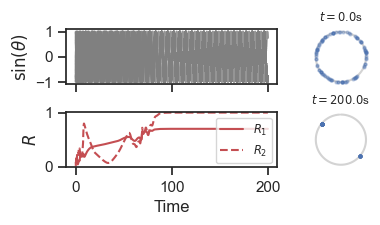

In [98]:
# plot the last repetition
i = 5
j = 3
fig, axs = plot_sync(thetas_arr[i, j], times)

axs[0, 1].set_title(f"$t={times[0]}$s", fontsize="x-small")
axs[1, 1].set_title(f"$t={times[-1]}$s", fontsize="x-small")

axs[0, 0].set_xlabel("")
axs[1, 0].legend(loc="best", fontsize="x-small")

plt.subplots_adjust(hspace=0.5, top=0.8)

identify_state(thetas_arr[i, j])

# fig.suptitle(tag_params, fontsize="small")

# only to viz twisted states
# fig, ax = plt.subplots(figsize=(3, 3))
# ax, ims = xgi.draw(
#    H, pos=pos, node_fc=thetas_arr[i,j,-1] % (2 * np.pi), node_fc_cmap="twilight", node_size=5
# )
# plt.colorbar(ims[0], label="phase value")

In [148]:
dat = np.load("../code/thetas_arr.npy")

In [149]:
dat.shape

(100, 6, 30, 20001)

In [152]:
results = {}
k2s = [0, 0.5, 1, 1.5, 2, 2.5]

for j, k2 in enumerate(tqdm(k2s)):
    states = [identify_state(thetas, atol=0.5) for thetas in dat[:, j]]
    states_unique, counts = np.unique(states, return_counts=True)
    probs = counts / n_reps

    results[k2] = {}
    for state, prob in zip(states_unique, probs):
        results[k2][state] = prob

100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.60s/it]


In [153]:
results

{0: {'sync': 1.0},
 0.5: {'sync': 1.0},
 1: {'sync': 1.0},
 1.5: {'sync': 1.0},
 2: {'sync': 1.0},
 2.5: {'sync': 1.0}}